# Set-Up

In [ ]:
# Install packages

#!pip install -r requirements.txt

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import rasterio
import glob
import os
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import rasterio
from rasterio.enums import Resampling
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import os
import numpy as np

# Data Processing

In [ ]:
# Define functions to load and process Sentinel-2 data

def load_rgbnir_and_scl(safe_dir):
    """
    Load RGBNIR and SCL data from Sentinel-2 SAFE directory.
    Args:
        safe_dir (str): Path to the SAFE directory.
    Returns:
        rgbnir (np.ndarray): Stacked RGBNIR image.
        scl (np.ndarray): SCL image.
        profile (dict): Metadata profile of the images.
    """
    rgb_paths = sorted(glob.glob(os.path.join(safe_dir, "GRANULE", "*", "IMG_DATA", "R10m", "*_B0[2-4]_10m.jp2")))
    nir_path = glob.glob(os.path.join(safe_dir, "GRANULE", "*", "IMG_DATA", "R10m", "*_B08_10m.jp2"))[0]
    scl_path = glob.glob(os.path.join(safe_dir, "GRANULE", "*", "IMG_DATA", "R20m", "*_SCL_20m.jp2"))[0]

    with rasterio.open(rgb_paths[0]) as r:
        profile = r.profile
        r_data = r.read(1)
    with rasterio.open(rgb_paths[1]) as g:
        g_data = g.read(1)
    with rasterio.open(rgb_paths[2]) as b:
        b_data = b.read(1)
    with rasterio.open(nir_path) as nir:
        nir_data = nir.read(1)

    with rasterio.open(scl_path) as scl_src:
        scl = scl_src.read(
            1,
            out_shape=(1, profile["height"], profile["width"]),
            resampling=Resampling.nearest
        )

    # Stack R, G, B, NIR
    rgbnir = np.stack([r_data, g_data, b_data, nir_data], axis=-1)
    return rgbnir, scl, profile


def extract_paired_patches(cloudy_rgbnir, clear_rgbnir, scl, patch_size=256, stride=64, min_cloud=0.05, max_cloud=0.3):
    """
    Extract patches from cloudy and clear RGBNIR images, along with SCL and cloud fraction.
    Args:
        cloudy_rgbnir (np.ndarray): Cloudy RGBNIR image.
        clear_rgbnir (np.ndarray): Clear RGBNIR image.
        scl (np.ndarray): SCL image.
        patch_size (int): Size of the patches to extract.
        stride (int): Stride for patch extraction.
        min_cloud (float): Minimum cloud fraction for a patch to be considered valid.
        max_cloud (float): Maximum cloud fraction for a patch to be considered valid.
    Returns:
        paired_patches (list): List of tuples containing (cloudy_patch, clear_patch, scl_patch, cloud_fraction).
    """
    paired_patches = []
    h, w = scl.shape
    for i in range(0, h - patch_size, stride):
        for j in range(0, w - patch_size, stride):
            scl_patch = scl[i:i+patch_size, j:j+patch_size]
            cloud_mask = np.isin(scl_patch, [8, 9, 10])  # cloud classes in SCL
            cloud_fraction = cloud_mask.sum() / (patch_size * patch_size)

            if min_cloud <= cloud_fraction <= max_cloud:
                cloudy_patch = cloudy_rgbnir[i:i+patch_size, j:j+patch_size, :]
                clear_patch = clear_rgbnir[i:i+patch_size, j:j+patch_size, :]
                paired_patches.append((cloudy_patch, clear_patch, scl_patch, cloud_fraction))
    return paired_patches


In [ ]:
# Get paired 256x256 pixel patches

cloudy_rgbnir, scl, _ = load_rgbnir_and_scl("/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/cloudy/pair_0000_cloudy/S2B_MSIL2A_20240304T212519_N0510_R043_T07WDS_20240304T222852.SAFE")
clear_rgbnir, _, _ = load_rgbnir_and_scl("/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/clear/pair_0000_clear/S2A_MSIL2A_20240312T213531_N0510_R086_T07WDS_20240313T010449.SAFE")  

paired_patches = extract_paired_patches(cloudy_rgbnir, clear_rgbnir, scl)

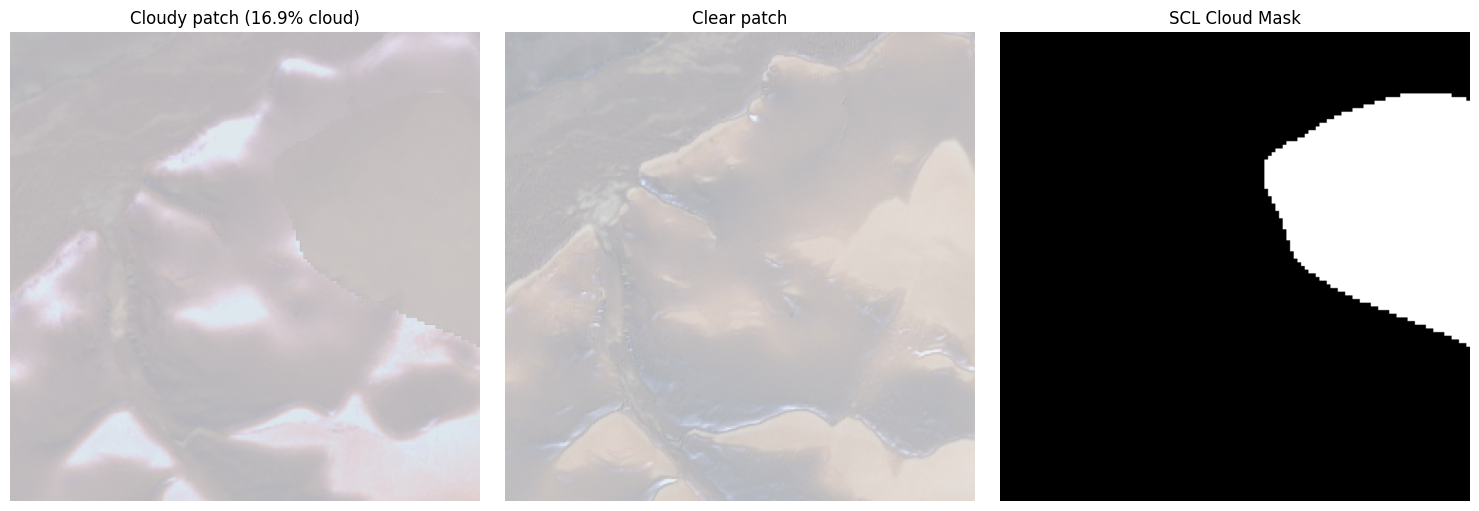

In [ ]:
# Visually inspect patches

cloudy_patch, clear_patch, scl_patch, frac = paired_patches[400]
cloud_mask = np.isin(scl_patch, [3, 8, 9, 10])  # Binary cloud mask

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cloudy_patch/16500)
axes[0].set_title(f"Cloudy patch ({frac:.1%} cloud)")
axes[0].axis("off")

axes[1].imshow(clear_patch/16500)
axes[1].set_title("Clear patch")
axes[1].axis("off")

axes[2].imshow(cloud_mask, cmap="gray")
axes[2].set_title("SCL Cloud Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Save the paired patches

base_dir = "/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp"
cloudy_dir = os.path.join(base_dir, "cloudy")
clear_dir = os.path.join(base_dir, "clear")

cloudy_patch_out = os.path.join(base_dir, "cloudy_patches")
clear_patch_out = os.path.join(base_dir, "clear_patches")
mask_patch_out = os.path.join(base_dir, "mask_patches")  # NEW
os.makedirs(cloudy_patch_out, exist_ok=True)
os.makedirs(clear_patch_out, exist_ok=True)
os.makedirs(mask_patch_out, exist_ok=True)  # NEW

# List of pair directories
pair_ids = sorted([d for d in os.listdir(cloudy_dir) if d.startswith("pair_")])

for pair_id in tqdm(pair_ids, desc="Processing pairs"):
    pair_index = pair_id.split("_")[1]
    cloudy_path = os.path.join(cloudy_dir, f"pair_{pair_index}_cloudy")
    clear_path = os.path.join(clear_dir, f"pair_{pair_index}_clear")

    # Get .SAFE folder inside each pair dir
    try:
        cloudy_safe = glob.glob(os.path.join(cloudy_path, "*.SAFE"))[0]
        clear_safe = glob.glob(os.path.join(clear_path, "*.SAFE"))[0]

        # Load images and SCL band
        cloudy_rgbnir, scl, _ = load_rgbnir_and_scl(cloudy_safe)
        clear_rgbnir, _, _ = load_rgbnir_and_scl(clear_safe)

        # Extract patches
        paired_patches = extract_paired_patches(cloudy_rgbnir, clear_rgbnir, scl)

        for idx, (cloudy_patch, clear_patch, scl_patch, cloud_frac) in enumerate(paired_patches):
            patch_id = f"patch_{pair_index}_{idx:03d}"

            # ✅ Create cloud mask (1 = cloud, 0 = clear)
            cloud_classes = [3, 8, 9, 10]  # cloud shadow, medium/thick cloud, cirrus
            cloud_mask = np.isin(scl_patch, cloud_classes).astype(np.uint8)  # shape (H, W)

            try:
                # Save each component
                np.save(os.path.join(cloudy_patch_out, patch_id + ".npy"), cloudy_patch)
                np.save(os.path.join(clear_patch_out, patch_id + ".npy"), clear_patch)
                np.save(os.path.join(mask_patch_out, patch_id + ".npy"), cloud_mask)  # NEW
            except Exception as e:
                print(f"❌ Error saving patch {patch_id}: {e}")
                print("Shape:", cloudy_patch.shape, "dtype:", cloudy_patch.dtype)

    except Exception as e:
        print(f"❌ Error processing {pair_id}: {e}")


Processing pairs: 100%|██████████| 13/13 [14:21<00:00, 66.29s/it]


In [ ]:
# Get number of patches saved

cloudy_files = len(glob.glob(os.path.join(cloudy_patch_out, "*.npy")))
print(f"Number of cloudy-clear patch pairs: {cloudy_files}")

Number of cloudy-clear patch pairs: 37661


# Visualize Training Image Pairs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1565..1.00475].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.134625..1.007625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1274375..1.0065].


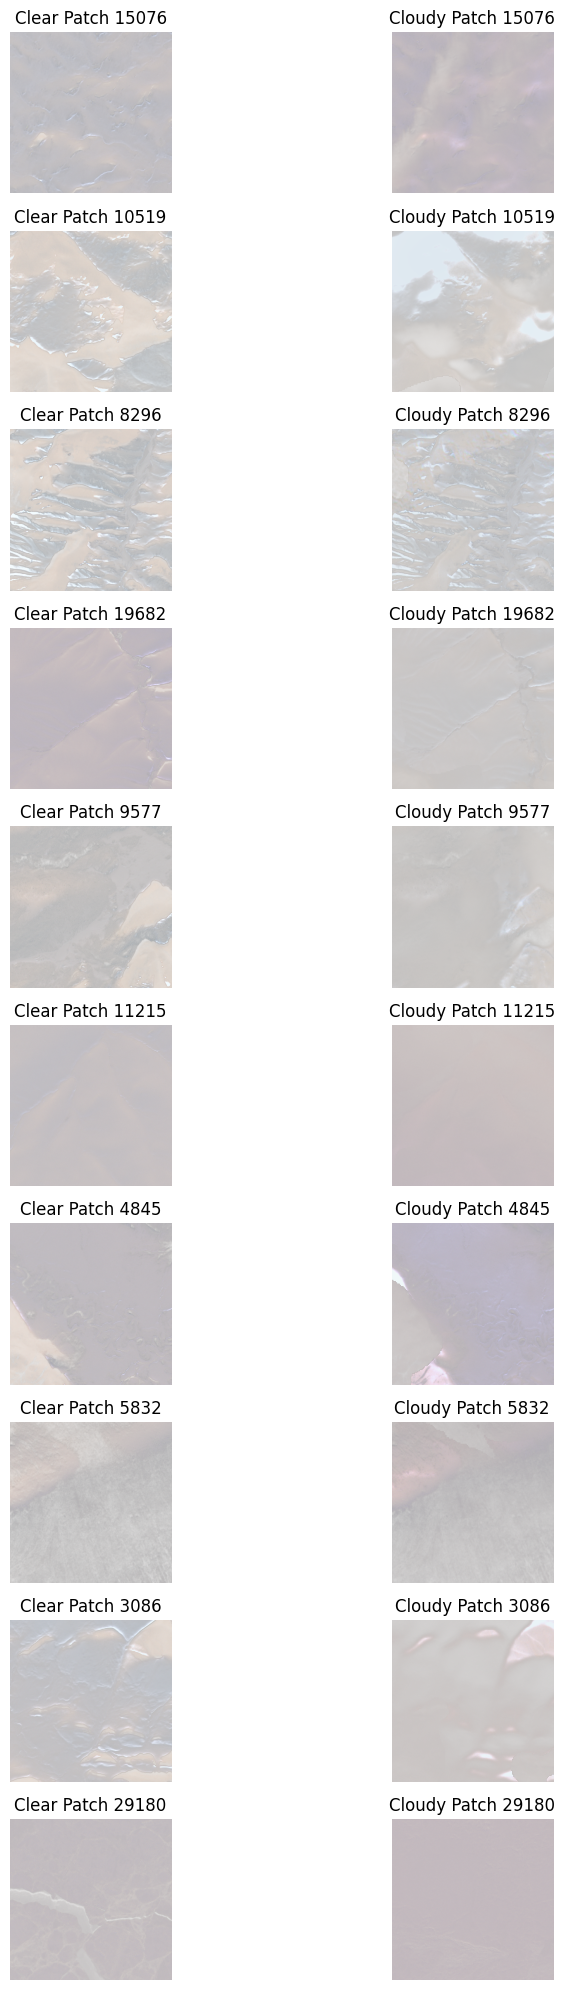

In [27]:
# Visualize 10 samples of cloudy-clear patch pairs

# Set the directory containing the patches
cloudy_patch_out = "/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/cloudy_patches"
clear_patch_out = "/Users/tessacannon/Documents/UCL/AI4EO/Cloud Removal Project/temp/clear_patches"

# Get a list of all the patch files
cloudy_files = sorted(glob.glob(os.path.join(cloudy_patch_out, "*.npy")))
clear_files = sorted(glob.glob(os.path.join(clear_patch_out, "*.npy")))

# Randomly select 10 pairs of patches
num_samples = 10
sample_indices = random.sample(range(len(cloudy_files)), num_samples)

# Create a figure with subplots
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

# Loop through the selected indices and plot the patches
for i, idx in enumerate(sample_indices):
    # Load the patches
    cloudy_patch = np.load(cloudy_files[idx])
    clear_patch = np.load(clear_files[idx])
    # Plot the patches
    axes[i, 0].imshow(clear_patch/16000)
    axes[i, 0].set_title(f"Clear Patch {idx}")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(cloudy_patch/16000)
    axes[i, 1].set_title(f"Cloudy Patch {idx}")
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()